In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [26]:
def radial_corr(data):
    N = data.shape[1]
    L = int(N**0.5)
    rsq = np.array([])
    gr = np.array([])
    covmat = np.cov(data.T)
    for i in range(N):
        ix = i%L
        iy = np.floor(i/L).astype(np.int32)
        for j in range(i,N):
            jx = j%L
            jy = np.floor(j/L).astype(np.int32)
            rsq = np.append(rsq, (ix-jx)**2 + (iy-jy)**2)
            gr = np.append(gr,covmat[i][j])
    ord = np.argsort(rsq)
    ordgr = gr[ord]
    ordrsq = rsq[ord]
    dist, dist_c = np.unique(np.sqrt(rsq), return_counts=True)
    start = 0
    gr = np.array([])
    for i in range(len(dist_c)):
        end = start + dist_c[i]-1
        gr = np.append(gr,np.mean(ordgr[start:end]))
        start = end +1
    table = dist < L*2
    return dist[table],gr[table]

In [27]:
def load_data(L,diffTemp,P,temp,nSteps,dt,last = False):
    if last:
        return np.load(f"x_recon_L{L}_annealed/x_recon_L{L}_T{temp:.3f}_difftemp{diffTemp[0]:.3f}_{diffTemp[-1]:.3f}.npy")[:,0,:]
    else:
        return np.load(f"x_recon_L{L}_annealed/x_recon_L{L}_T{temp:.3f}_difftemp{diffTemp[0]:.3f}_{diffTemp[-1]:.3f}.npy")
    
def load_data_lin(N,difftemp,P,temp,nSteps,dt,last = True):
    if last:
        return np.load(f"data_N{N}_T{difftemp[-1]:.3f}_P{P}/recon_temp{temp:.3f}_nSteps{nSteps}_dt{dt:.2f}.npy")[:,0,:]
    else:
        return np.load(f"data_N{N}_T{difftemp[-1]:.3f}_P{P}/recon_temp{temp:.3f}_nSteps{nSteps}_dt{dt:.2f}.npy")
    
def load_original_data(L,temp,MCS):
    return np.fromfile(f"../ising_wolff/dataIsing2D_L{L}/config_L{L}_T{temp:.3f}.bin",dtype = np.int32).reshape(MCS,L**2)

In [28]:
Ls = np.array([8,10,12,14])
Tmin = 2.27
Tmax = 3.22
meas = 20
Ts = np.linspace(Tmin,Tmax,meas)
diffTemp = np.linspace(0.001,2,20)
nSteps = 300
dt = 0.02
P = 100000

Let's look at the radial correlation, for different cases.
Pure, linear score, non linear score

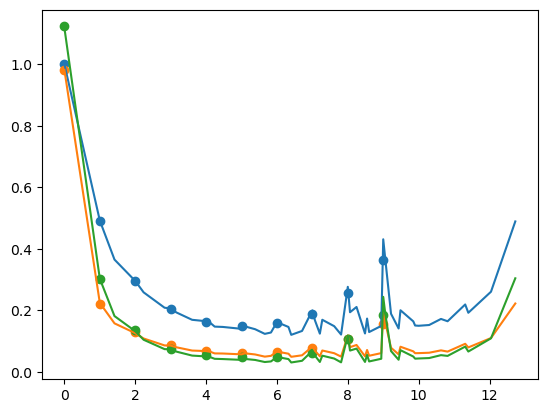

In [30]:
idx = 9
data = load_original_data(Ls[1],Ts[idx],200000)
data_recon_lin = load_data_lin(Ls[1]**2,diffTemp,100000,Ts[idx],nSteps,dt,last=True)
data_recon = load_data(Ls[1],diffTemp,100000,Ts[idx],nSteps,dt,last=False)

dist,gr = radial_corr(data)
dist,gr_recon_lin = radial_corr(data_recon_lin)
dist,gr_recon = radial_corr(data_recon)
cov1 = np.cov(data.T)
cov2 = np.cov(data_recon_lin.T)
cov3= np.cov(data_recon.T)
plt.plot(dist,gr)
plt.plot(dist,gr_recon)
plt.plot(dist,gr_recon_lin)
plt.scatter([*range(10)],cov1[0,:10])
plt.scatter([*range(10)],cov3[0,:10])
plt.scatter([*range(10)],cov2[0,:10])
#plt.yscale("log")
#plt.imshow(np.cov(data_recon.T))
#plt.colorbar()

In [8]:
susc_true = np.zeros((len(Ls),len(Ts)))
susc_recon = np.zeros((len(Ls),len(Ts)))
for l,L in enumerate(Ls):
    N = L**2
    for t,T in enumerate(Ts):
        data = load_data(L,diffTemp,P,T,nSteps,dt)
        magn = np.mean(data,axis = 1)
        susc_recon[l][t] = L**2*(np.mean(magn**2) - np.mean(magn)**2)/T
        data = load_original_data(L,T,200000)
        magn = np.mean(data,axis = 1)
        susc_true[l][t] = L**2*(np.mean(magn**2) - np.mean(magn)**2)/T
        del data

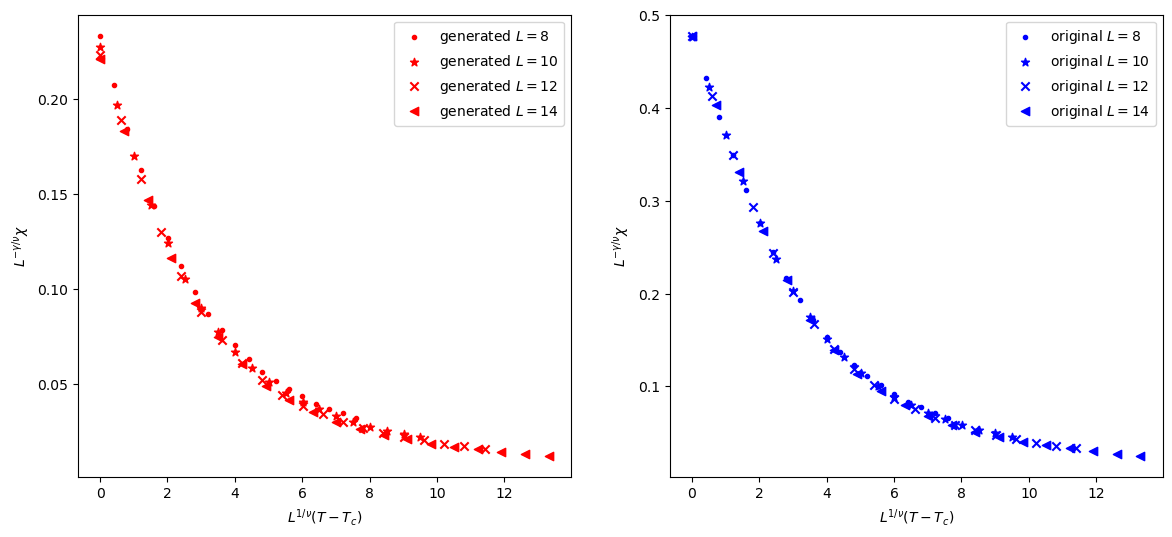

In [35]:
Tc = 2/np.log(1+2**0.5)
plt.figure(figsize = (14,6))
mks = [".","*","x","<"]
for l,L in enumerate(Ls):
    plt.subplot(1,2,1)
    plt.scatter(L*(Ts-Tc),susc_recon[l]*L**(-7/4),color = "red",marker=mks[l],label = rf"generated $L = {L}$")
    plt.xlabel(r"$L^{1/\nu}(T-T_c)$")
    plt.ylabel(r"$L^{-\gamma/\nu}\chi$")
    plt.legend()
    plt.subplot(1,2,2)
    plt.scatter(L*(Ts-Tc),susc_true[l]*L**(-7/4),color = "blue",marker=mks[l],label = rf"original $L = {L}$")
    plt.xlabel(r"$L^{1/\nu}(T-T_c)$")
    plt.ylabel(r"$L^{-\gamma/\nu}\chi$")
    plt.legend()


In [36]:
def getBinder(data):
    return 1-np.mean(data**4)/(3*np.mean(data**2)**2)

In [37]:
binder_true = np.zeros((len(Ls),len(Ts)))
binder_recon = np.zeros((len(Ls),len(Ts)))
for l,L in enumerate(Ls):
    N = L**2
    for t,T in enumerate(Ts):
        data = load_data(L,diffTemp,P,T,nSteps,dt)
        magn = np.mean(np.sign(data),axis = 1)
        binder_recon[l][t] = getBinder(magn)
        data = load_original_data(L,T,200000)
        magn = np.mean(data,axis = 1)
        binder_true[l][t] = getBinder(magn)
        del data

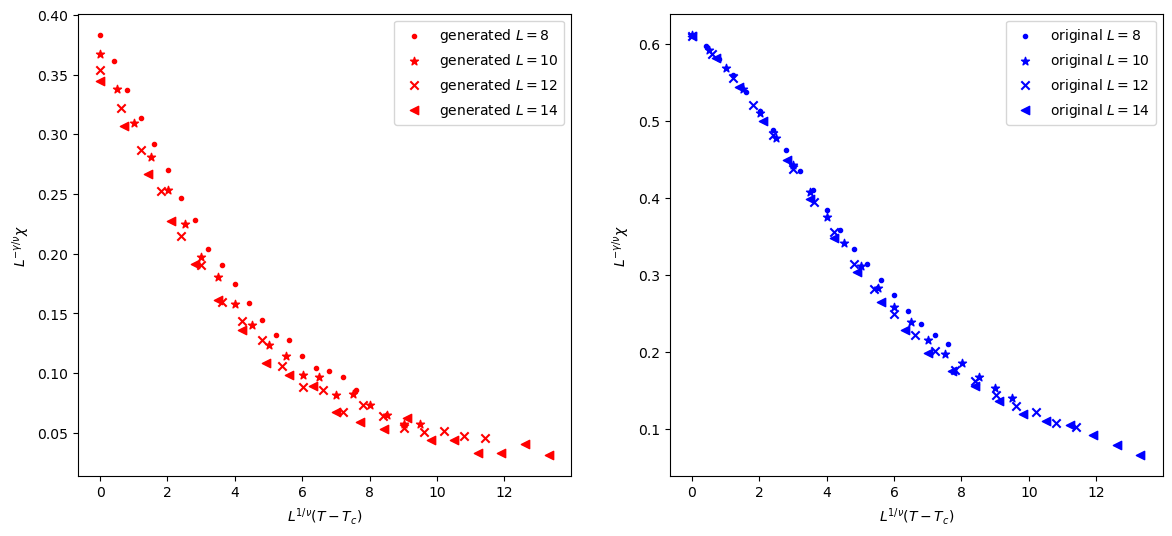

In [38]:
Tc = 2/np.log(1+2**0.5)
plt.figure(figsize = (14,6))
mks = [".","*","x","<"]
for l,L in enumerate(Ls):
    plt.subplot(1,2,1)
    plt.scatter(L*(Ts-Tc),binder_recon[l],color = "red",marker=mks[l],label = rf"generated $L = {L}$")
    plt.xlabel(r"$L^{1/\nu}(T-T_c)$")
    plt.ylabel(r"$L^{-\gamma/\nu}\chi$")
    plt.legend()
    plt.subplot(1,2,2)
    plt.scatter(L*(Ts-Tc),binder_true[l],color = "blue",marker=mks[l],label = rf"original $L = {L}$")
    plt.xlabel(r"$L^{1/\nu}(T-T_c)$")
    plt.ylabel(r"$L^{-\gamma/\nu}\chi$")
    plt.legend()
